# SIS

Compartmental models consider an initial population of susceptible individuals where an infectious agent has been introduced and simulate the dynamics of a disease by studying the susceptible individuals that become infected over time. They assume that the population is divided into subsets of individuals or compartments with epidemiological characteristics. These models are deterministic, so that the initial parameters are fixed and consequently, the model predictions are determined by these initial conditions. 

There are various compartmental model structures, however, the available data limit the study to a specific type of model: the SIS (Susceptible-Infected-Susceptible) model. Let $S(t)$ be the compartment formed by the susceptible individuals at time $t$, $I(t)$ the compartment constituted by those individuals infected (assuming that every infected individual is infectious, i.e. capable of transmitting the infection) at time $t$. This model is used to describe infections that do not provide permanent immunity after overcoming them, therefore, an infected individual upon recovery becomes susceptible again. This occurs in the case of COVID-19: there are reinfections. 

Transitions of individuals between compartments are described by the following system of differential equations:

\begin{align}
    & \frac{dS}{dt} = -\beta S \frac{I}{N} + \gamma I, \\
    & \frac{dI}{dt} = \beta S \frac{I}{N} - \gamma I
\end{align}

where $N$ is the total population and the constants $\beta$ and $\gamma$ are detailed below. It follows that $\frac{dI}{dt}=(\beta-\gamma)I-\frac{\beta}{N}I^{2}$, this is the same as assume that the dynamics of the infection follows a logistic function. 

The above model is based on the following assumptions and simplifications:

- The total population $N(t)$ is closed, that is, no natural births and deaths are considered. Therefore, $N(t)$ is constant and $dS/dt+dI/dt=0$, which implies that $N(t) = S(t) + I(t)$.
- Homogeneous contact or assume that contacts between susceptible and infectious individuals occur randomly. The probability that a susceptible individual has contact with an infectious individual is $I/N$. The constant $\beta(N)$ is the contagion rate (probability that a susceptible becomes infected having been in contact with an infectious), which depends on the population. The term $\beta(N) S I/N$ is the incidence or new infected cases per unit time.  
- The rate of recovery from infection and death per capita $\gamma$ is constant. This implies that the time an individual remains infected has exponential distribution of mean $1/\gamma $. 

Note that these hypotheses do not hold for this case: total population is neither constant nor closed (mobility is allowed in Spain since the end of the state of alarm); COVID-19 spread is not homogeneous but heterogeneous since a small fraction of the total population is responsible for most infections [(Szapudi, Istvan (2020). Heterogeneity in SIR epidemics modeling: superspreaders and herd immunity.)](https://sci-hub.hkvisa.net/10.1007/s41109-020-00336-5) and there are several clusters of superspreading such as care facilities, restaurants and bars, workplaces, music events, etc [(Furuse, Y., Sando, E., Tsuchiya, N., Miyahara, R., Yasuda, I., Ko, Y. K....Oshitani, H. (2020). Clusters of Coronavirus Disease in Communities)](https://sci-hub.hkvisa.net/10.3201/eid2609.202272).

Despite these simplifications, this model has proven useful in epidemic modeling. The objective of this analysis is to test the ability of the SIS model to capture the patterns in the series, even if it departs from the starting assumptions.


**Notes about the predictions**

It is clear that extracting isolated predictions is meaningless in any type of problem; any prediction generated has to serve a purpose or be used to solve some problem. In this case, predictions are obtained to help in future decision making that surrounds (and has surrounded) the evolution of the COVID-19 pandemic. In this sense, forecasts up to 14 days are considered to be the most important for defining any strategy. These predictions are interpreted as follows: if current conditions continue, these infections are expected in the next 14 days.


## Setup

In [1]:
# data handling
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

# visualizations
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# for compartmental models
import comod

# import functions from utils
from utils import *

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# set seed to replicate results
seed=123

# Data

Read saved static data (csv file) of COVID-19 cases in Spain. More info in https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos. These data have been previously processed to add the total Spanish population (assumed constant) and recovered cases. The recovered column was added to compare the performance of the model with the SIR, although it is not used in this study (the existence of this compartment is not considered). 

The original series of infected persons has been transformed into a variable with greater epidemiological importance: the cumulative incidence series.
In addition, this transformation eliminates the seasonal pattern that was observed during the exploration of the original data. It was shown that this pattern was not the result of an inherent characteristic of the virus dynamics, but a consequence of the structure of the work calendar.

In [2]:
# read processed data
path = 'cumulative-incidence-14-days.csv'
df = load_last_final_data(file_name=path)
df.head()

c:\Users\Bisite\Desktop\COVID-Dynamics-Model-Comparison\data\final-data\cumulative-incidence-14-days.csv


,Infected
Date,
2020-02-21,0.010685
2020-02-22,0.012821
2020-02-23,0.014958
2020-02-24,0.019232
2020-02-25,0.021369


Plot smooth infected curve:

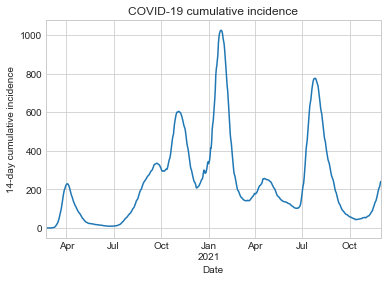

In [3]:
# plot infected curve
df['Infected'].plot()
plt.title('COVID-19 cumulative incidence')
plt.ylabel('14-day cumulative incidence')
plt.xlabel('Date')
plt.show()

The graph shows sharp rises and falls in the number of infected over time. This is due to the successive application of containment and control measures by the Spanish government. Social events or vacations may also favor the increase of cases. 

## Prepare data 

Before further analysis, data must be prepared to fit the model implementation:
- Population is saved as constant in POPULATION variable (as the cumulative incidence rate is taken, the population considered is not the Spanish population but 100000 inhabitants).
- Only variables needed for the analysis are kept: susceptible and infected cases. 
- Transform dates to integer timesteps to prevent unexpected errors when handling datetime types. 
- Transform data from DataFrame to arrays S, I to speed up computations. 

In [4]:
# constant population
POPULATION = 100000

# select only infected series of data
df2 = df[['Infected']]

In [5]:
# to SI form
def CDRA_to_SIS(df, population):
    df2 = df[[]].copy()
    df2["S"] = 0  # Just to produce the desired order
    df2["I"] = df[["Infected"]]
    df2["S"] = population - df2["I"]
    return df2

In [6]:
# transform data
df3 = CDRA_to_SIS(df2, POPULATION)

In [7]:
# use day count instead of datetime
t = np.linspace(0, len(df3)-1, len(df3))

# S, I to array
S = df3['S'].values
I = df3['I'].values


After completing the data preparation phase, the number of susceptibles over time is plotted to visually check if it has been well transformed.

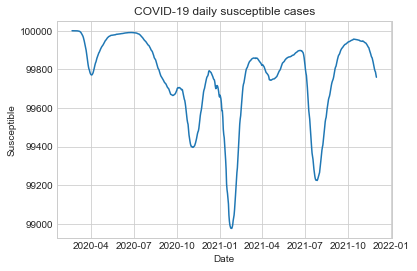

In [8]:
# plot all avaible data of susceptible cases
plt.plot(df3.index, df3['S'])
plt.title('COVID-19 daily susceptible cases')
plt.ylabel('Susceptible')
plt.xlabel('Date')
plt.show()

# # or plot a subset 
# sns.lineplot(df3.index[50:200], df3['S'][50:200])
# plt.show()

**Interpretation of the graph**

- At the beginning of the pandemic the entire population is considered as susceptible. As infections increase, many susceptible people become infected and the number of susceptible people decreases. In absence of immunity, the number of susceptibles fluctuates over time depending on the infections produced. 
- Note that the scale of susceptibles is much larger than the scale of infected: the number of registered infected is a very small percentage of the total population. 
- It should also be noted that the number of reported infections should be interpreted as a small fraction of the actual number infected: not all cases are diagnosed (asymptomatic) and not all cases are reported.

# SIS modeling

To fit the SIS model, the package comod is used (doc: https://comod.readthedocs.io/en/latest/). 

It is not adequate to fit a single SIS model to all available data: SIS model is deterministic, so given an initial state, the solution is uniquely determined by it. This approach is unrealistic since the number of infected people changes over time depending on the measures applied, and therefore the parameters change as well. For example, setting the infection rate at the beginning of the series is equivalent to assuming that during the quarantine, this infection rate was exactly the same which is not possible because contacts were reduced.
Therefore, small time windows need to be considered to fit a SIS model on each: the initial values of $S, I$ in each window will determine the predictions.

## Methodology

The procedure is as follows:
1. Choose the number of time steps in the past over which to adjust a SIS model (window_size) and the number of time steps in the future to get forecasts (steps_ahead).
2. The series consisting of the S, I compartments is taken and divided into successive train-test windows of fixed sizes "window_size" and "steps_ahead" (see [walk forward graph](https://github.com/marialonsogar/COVID-Dynamics-Model-Comparison/blob/main/analysis/walk-forward-scheme.png).
3. Take the values of S, I from each train window and estimate the parameters $\beta$ and $\gamma$. Then, given the initial state of the compartiments for the given window $(S_0, I_0)$ the system of differential equations is solved and therefore values of $S, I$ for a given $t$ are generated; forecasts are obtained by setting as initial state the last known value of train window $(S_{window\_size-1}, I_{window\_size-1})$ and solving the corresponding system. 
4. Once a SIS model is fit for the train window given, it is used to predict the "steps_ahead" next steps of time.
5. Predictions are compared to the corresponding test window (made of "steps_ahead" time steps consecutive to the train window) to evaluate the goodness of the fit. 
6. Repeat this for all data available.

For ease of analysis, the class WindowFit is defined. Given all data, the class generates the necessary windows, plots and evaluates the predictions. Two forms of evaluations are allowed: multiple train-test splits and walk-forward validation (recommended). This should be specified by the eval_mode parameter, which is 'WF' by default. The metrics considered to evaluate performance are defined in the variable metrics. 

For sake of comparison, a baseline or benchmark to beat has been defined. The baseline is taken by predicting for time t+1 the value of t, i.e., repeating the last value. This is a very trivial approximation, therefore a model will be considered useful or relevant if it is able to overcome it.

**Notes:**

- The function plot_windows(max_subplots) displays max_subplots plots made of a random train window followed by the corresponding test window, the forecasts and the baseline. Note that the purpose of this function is merely illustrative and the order of the series is always preserved as it is mandatory in any time series analysis.

In [9]:
class WindowFit:
    
    def __init__(self, data, window_size=22, steps_ahead=14, metrics=metrics, eval_mode='WF'):
        # parameters
        self.window_size = window_size
        self.steps_ahead = steps_ahead

        # store raw data
        self.data = np.array(data)
        self.train, self.test = self.train_test_split(self.data, eval_mode)
        self.baseline = self.get_baseline(self.train)

        # parameters
        self.beta_series = []
        self.gamma_series = []

        # metrics to evaluate
        self.metrics = metrics


    def train_test_split(self, data, eval_mode):
        """
        Split data into train and test subsets
        Args:
            data (pd.DataFrame or np.array): Data to be split
            eval_mode (str): Mode of evaluation, 'WF' for Walk Forward evaluation, 'MTTS' for Multiple Train Test Splits 
        Returns:
            train (numpy.ndarray): Train data
            test (numpy.ndarray): Test data
        """
        train, test = [], []

        if eval_mode == 'WF':
            # walk forward evaluation
            for compartiment in data:
                train.append(sliding_window_view(compartiment[:-(self.steps_ahead)], window_shape=self.window_size))
                test.append(sliding_window_view(compartiment[self.window_size:], window_shape=self.steps_ahead))

        elif eval_mode == 'MTTS':
            n_windows = data.shape[1]//(self.window_size+self.steps_ahead) # perfect windows 
            data_start_point = data.shape[1]%(self.window_size+self.steps_ahead) # data start to generate perfect windows sizes
            
            for compartiment in data:
                window = np.array(np.split(compartiment[data_start_point:], n_windows))
                train.append(window[:, :-self.steps_ahead])
                test.append(window[:, -self.steps_ahead:])
        else:
            raise ValueError('Evaluation mode not recognized')

        return np.array(train), np.array(test)

    def get_baseline(self, train):
        baselines = []
        for compartiment in train:
            baseline = []
            for window in compartiment:
                baseline.append(np.repeat(window[-1], self.steps_ahead))           
            baselines.append(np.array(baseline))
        return np.array(baselines)

    def fit_predict(self, window, return_only_predictions=False):
        """
        Fit the model to a window and predict the future

        Args:
            window (numpy.ndarray): a window with [S, I, R] data to fit SIR model and predict future

        Returns:
            predictions (numpy.ndarray): a window with [S, I, R] data predicted from the fitted SIR model

        """
        # define a SIR model
        model = comod.Model("SI",
            ["beta", "gamma"],
            [
                ("S", "I", "beta I / N"),
                ("I", "S", "gamma")
            ],
            # Special state names can be set with the following options:
            # Total population. Can be used in the coefficients, but not as origin/destination.
            sum_state="N", 
            # The nothingness (?) from which one is born and to which one dies.
            nihil_state="!",  # Can be used as origin/destination, but not in the cofficients.
        )
        
        # define time mesh
        t_window = np.arange(self.window_size) # time mesh for the window with step_size>window_size
        
        # get best-fit parameters
        fit_pars = model.best_fit(
            np.asarray(window), t_window, [0.01, 1/10], # Existing data  # Time mesh  # Initial guess
            target='y',
            ls_kwargs={'bounds':(0., np.inf)}  
        ).x

        # get fitted parameters
        fit_beta, fit_gamma = fit_pars
        self.beta_series.append(fit_beta)
        self.gamma_series.append(fit_gamma)

        # initial states:
        S0_train, I0_train = window[0][0], window[1][0]
        S0_pred, I0_pred= window[0][-1], window[1][-1]

        # solve the model numerically
        S_simulated, I_simulated = model.solve(
            (S0_train, I0_train),  # Initial state
            [fit_beta, fit_gamma],  # Coefficient values
            t=np.arange(self.window_size),  # Time mesh
            method="RK45",  # see scipy.integrate.solve_ivp
        )

        # solve the model numerically
        S_pred, I_pred = model.solve(
            (S0_pred, I0_pred),  # Initial state
            [fit_beta, fit_gamma],  # Coefficient values
            t=np.arange(self.window_size, self.window_size+self.steps_ahead),  # Time mesh
            method="RK45",  # see scipy.integrate.solve_ivp
        )

        if return_only_predictions is True:
            return S_pred, I_pred
        else:
            return np.append(S_simulated, S_pred), np.append(I_simulated, I_pred)
        
    def random_windows(self, return_baseline=False):
        """
        Generate random windows
        """        
        random_index = np.random.randint(0, self.train.shape[1])
        random_window_train, random_window_test = self.train[:, random_index], self.test[:, random_index]
        if return_baseline is True:
            random_window_baseline = self.baseline[:, random_index]
            return random_window_train, random_window_test, random_window_baseline[1]
        else:
            return random_window_train, random_window_test

    def plot_windows(self, max_subplots=3):
        """
        Plot real infected data, the predictions and the baseline to compare
        Args:
            max_subplots (int): maximum number of subplots to plot
        """
        # seed to replicate results 
        np.random.seed(seed)

        example_windows = [self.random_windows(return_baseline=True) for _ in range(max_subplots)]

        for train_window, test_window, baseline_window in example_windows:
            t_window = np.arange(self.window_size+self.steps_ahead)

            _, I_simulated = self.fit_predict(train_window, return_only_predictions=False)

            plt.figure(figsize=(8, 5))
            plt.scatter(t_window[:self.window_size], train_window[1], color='dodgerblue', label='I real')
            plt.plot(t_window[:self.window_size], I_simulated[:self.window_size], color='orange', label='I simulated', marker='o')
            plt.plot(t_window[-self.steps_ahead:], I_simulated[-self.steps_ahead:], color='darkorange', label='I predicted', marker='o')
            plt.scatter(t_window[-self.steps_ahead:], test_window[1], color='blue', label='I test')
            plt.plot(t_window[-self.steps_ahead:], baseline_window,  marker='o', color='silver', label='I baseline')

            plt.ylabel('Infected')
            plt.xlabel('Time steps')
            plt.legend()
            plt.show()

    def get_all_predictions(self, horizon):
        """
        Get all predictions in a single array for a time horizon of 'horizon'

        Args:
            horizon (int): time horizon to predict
        """
        predictions = []
        for i in range(0, self.train.shape[1]):
            window = self.train[:, i]
            _, I_pred = self.fit_predict(window, return_only_predictions=True)
            predictions.append(I_pred[(horizon-1)])
        return np.array(predictions)

    def get_predictions_df(self, horizon=None, subset=None):
        if horizon is None:
            horizon = self.steps_ahead        
        y_pred = []
        for i in range(self.train.shape[1]):
            window_train = self.train[:, i]
            _, I_simulated = self.fit_predict(window_train, return_only_predictions=True)
            y_pred.append(I_simulated)

        y_fit = pd.DataFrame(y_pred, columns=[f'y_step_{i}' for i in range(1,horizon+1)])
        if subset == 'train':
            y_fit['Date'] = df[:len(self.data[1])]['Infected'].index[self.window_size:(len(y_fit)+self.window_size)]
        elif subset == 'test':
            y_fit['Date'] = df[-len(self.data[1]):]['Infected'].index[self.window_size:(len(y_fit)+self.window_size)]
        else:
            y_fit['Date'] = np.arange(0, len(self.data))
        y_fit.set_index(['Date'], inplace=True)
        return y_fit

    def get_residuals(self, horizon):
        """
        Get the residuals (residuals = expected_value-forecast_value) for a time horizon of 'horizon'
        """
        I_pred_total = self.get_all_predictions(horizon)
        I_true = self.test[1][:, horizon-1]
        return I_true - I_pred_total # forecast errors

    def evaluate(self):
        """
        Evaluate the performance of the model
        """
        evaluation = {}

        # evaluate per timesteps
        for i in range(0, self.steps_ahead):
            sir_step_evaluation, baseline_step_evaluation = {}, {}

            test_step = self.test[1][:, i] 
            predicted_step = self.get_all_predictions(horizon=i+1)
            baseline_step = self.baseline[1][:, i]

            # evaluate
            for metric_name, metric in self.metrics.items():
                try:
                    sir_step_evaluation[metric_name] = metric(test_step, predicted_step)
                    baseline_step_evaluation[metric_name] = metric(test_step, baseline_step)
                except:
                    sir_step_evaluation[metric_name] = np.nan
                    baseline_step_evaluation[metric_name] = np.nan

                evaluation[f'step_{i+1}'] = sir_step_evaluation
                evaluation[f'baseline_step_{i+1}'] = baseline_step_evaluation

        return evaluation

## Fit

An example of how to use the previous class to adjust a model to successive windows of size window_size=7 (7 time steps) to predict the next steps_ahead=3 (3 time steps) is shown below. That is, predict the infected cases for the next 3 days knowing the infected cases values of the previous 7 days. 

In [10]:
# create an object of the class
w = WindowFit(window_size=7, steps_ahead=3, data=[S, I], eval_mode='WF')

# get a random train and test window
window_train, window_test = w.random_windows()
# fit the model and get the predictions
S_simulated, I_simulated= w.fit_predict(window_train, return_only_predictions=True)

# print the predictions of infected individuals for the random window 
print(f'I predicted: {I_simulated}') 

I predicted: [218.88797762 224.85025429 230.76912886]


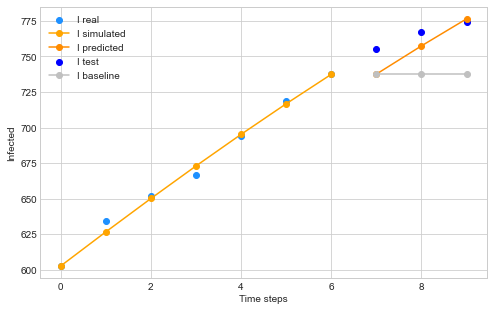

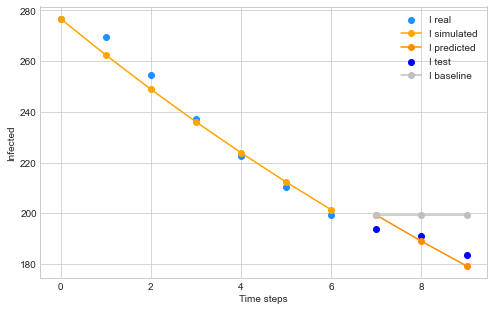

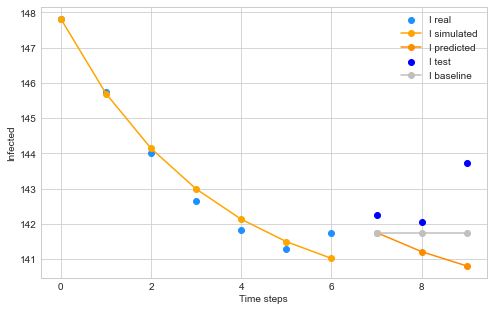

In [11]:
# fit model and plot the results for 3 random windows
w.plot_windows(max_subplots=3)

This was just an example of using the class defined above for any window_size and steps_ahead. The objective now is to get the window_size that minimizes the prediction error on horizon 14.

## Evaluation

First it is shown how to use the evaluation method defined in the class and then it is used to find the optimal window size.

To make this type of model comparable to other types of models, only the last 30% of the series is considered for evaluation. To be consistent with classical machine learning nomenclature, this subset is called test_data since it is used to evaluation. Note that this subset is not the same as the test windows defined above.

The subset called train_data will be used later to get the best window_size.


In [12]:
# define test size as the 30% of total data points
test_size = int(0.3*len(df))
train_data = [S[:-test_size], I[:-test_size]]
test_data = [S[-test_size:], I[-test_size:]]

Below is shown how to perform the evaluation using windows of 22 past points to forecast up to 14 days in the future. Different metrics are used to determine the quality of the predictions at each time step. 

In [13]:
# evaluate the model
w_eval = WindowFit(window_size=22, steps_ahead=14, data=test_data, eval_mode='WF')
e = w_eval.evaluate()
# show the evaluation as DataFrame
pd.DataFrame(e).style.highlight_min(axis=1)

,step_1,baseline_step_1,step_2,baseline_step_2,step_3,baseline_step_3,step_4,baseline_step_4,step_5,baseline_step_5,step_6,baseline_step_6,step_7,baseline_step_7,step_8,baseline_step_8,step_9,baseline_step_9,step_10,baseline_step_10,step_11,baseline_step_11,step_12,baseline_step_12,step_13,baseline_step_13,step_14,baseline_step_14
RMSLE,0.047462,0.047462,0.082776,0.093346,0.119295,0.138622,0.155098,0.183363,0.190850,0.227610,0.227472,0.271746,0.265218,0.316037,0.304179,0.360574,0.343762,0.404910,0.383484,0.448852,0.423209,0.492153,0.463021,0.534700,0.503234,0.576813,0.543991,0.618613
MAE,9.403775,9.403775,15.590816,18.785147,22.075849,28.213127,28.985209,37.640086,36.271687,47.030690,44.204863,56.419911,52.626676,65.798513,61.611099,75.158529,71.072174,84.542723,81.038020,93.876289,91.599442,103.154525,102.705648,112.397346,114.335500,121.518566,126.492046,130.636331
RMSE,13.856614,13.856614,25.787784,27.409888,37.951217,40.732269,49.556477,53.907790,61.182359,66.949558,73.117570,79.883757,85.662047,92.761763,99.136278,105.594702,113.543371,118.281937,128.890786,130.755643,145.265660,142.979668,162.757082,154.934704,181.440807,166.650344,201.447690,178.142469
MAPE,0.037996,0.037996,0.059989,0.075102,0.082080,0.112047,0.104340,0.148704,0.127532,0.185381,0.151896,0.222091,0.177315,0.259103,0.204001,0.296387,0.231341,0.333978,0.259371,0.371817,0.287746,0.410053,0.317230,0.448607,0.348280,0.487840,0.380648,0.527672


It should be noted that the lower the error, the better the forecast. In this analysis the point of interest is the 14-day forecast. Naturally, the further away the horizon to be predicted, the greater the uncertainty and therefore the greater the error.

## Estimation of best window size

The code below evaluates the results for different window sizes and the table highlights the best ones (lower ones) for 14 steps ahead. The train_data subset defined above will be used for this purpose.

In [14]:
# define a dict to store results
eval_window_size = {}

for window_size in range(2, 19):
    print(f'Evaluating SIS for window size {window_size}...')
    # define object and evaluate it per window_size 
    w = WindowFit(data=train_data, window_size=window_size, steps_ahead=14, eval_mode='WF')
    evaluation_metrics = w.evaluate()
    
    # store the evaluation of the 14th step (the most important one)
    window_error = evaluation_metrics['step_14']
    # save it to the dict
    eval_window_size[f'window_size_{window_size}'] = window_error

Evaluating SIS for window size 2...
Evaluating SIS for window size 3...
Evaluating SIS for window size 4...
Evaluating SIS for window size 5...
Evaluating SIS for window size 6...
Evaluating SIS for window size 7...
Evaluating SIS for window size 8...
Evaluating SIS for window size 9...
Evaluating SIS for window size 10...
Evaluating SIS for window size 11...
Evaluating SIS for window size 12...
Evaluating SIS for window size 13...
Evaluating SIS for window size 14...
Evaluating SIS for window size 15...
Evaluating SIS for window size 16...
Evaluating SIS for window size 17...
Evaluating SIS for window size 18...


In [15]:
# show the evaluations highlighting the best metrics
pd.DataFrame(eval_window_size).style.highlight_min(axis=1)

,window_size_2,window_size_3,window_size_4,window_size_5,window_size_6,window_size_7,window_size_8,window_size_9,window_size_10,window_size_11,window_size_12,window_size_13,window_size_14,window_size_15,window_size_16,window_size_17,window_size_18
RMSLE,0.593009,0.525780,0.481052,0.455966,0.454821,0.439902,0.431379,0.434785,0.439722,0.444941,0.456280,0.462684,0.468752,0.476163,0.481152,0.501081,0.498117
MAE,148.881233,96.078377,87.304651,88.040246,89.984940,88.818942,86.804525,89.735731,92.622621,95.365213,99.442526,103.850404,106.580124,109.941755,113.595109,121.202132,120.828818
RMSE,944.270595,202.617605,170.138631,160.460167,167.518501,162.205301,158.512868,165.649911,166.251503,171.247565,182.858192,194.380597,200.845882,214.923732,233.832692,270.552812,254.551257
MAPE,3.679827,0.685172,0.440291,0.390151,0.396078,0.385480,0.374188,0.377878,0.388034,0.398473,0.411802,0.423396,0.433511,0.446835,0.456866,0.489946,0.479063


Since it has been a time expensive operation (~300 min), it is convenient to save the results as a csv or json file:

In [16]:
eval_window_size_df = pd.DataFrame(eval_window_size)
# save csv in analysis folder of data
data_relative_path = '../data/analysis-data'
file_name = 'ci_SIS_window_size_estimation_metrics_target_ycsv'
path_to_save_file = os.path.join(data_relative_path, file_name)
eval_window_size_df.to_csv(path_to_save_file)
# print(eval_window_size_df.round(2).to_latex())

Show the evolution of each metric as the size of each window increases.

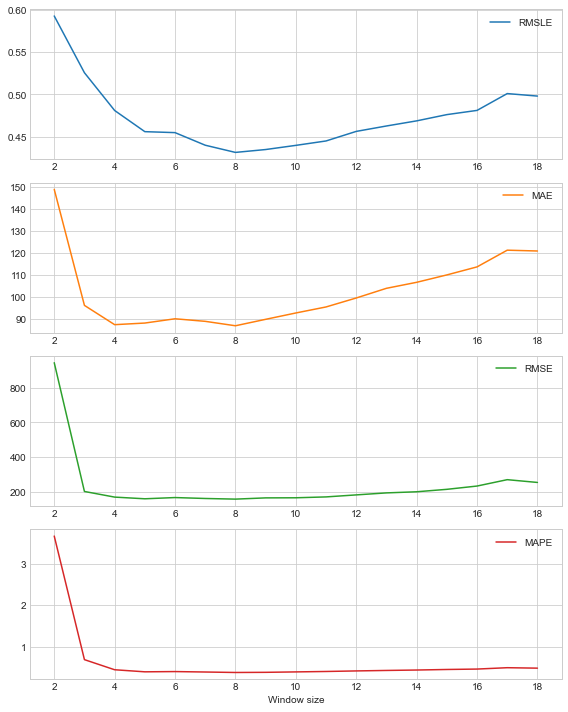

In [17]:
# metric evolution subplots
eval_window_size_df = pd.DataFrame(eval_window_size).T
eval_window_size_df.rename(index={k:f'{i}' for k,i in zip(eval_window_size_df.index, range(2,19))}, inplace=True)

fig, ax = plt.subplots(4, figsize=(8, 10), tight_layout=True)
ax = eval_window_size_df.plot(ax=ax, subplots=True)
plt.xlabel('Window size')
plt.show()

In conclusion:
- Some metrics increases from window size 8 onwards, in particular RMSLE, which can be considered as the most significant one in this case. 
- There seems to be unanimity on the best window size: the one with the best overall results is window of size 8.
- That the optimal window size is 8 (for horizon 14 forecasts) means that the dynamics of the curve change rapidly and that future values (up to 14) depend only on information about contagion and recovery from the previous 8 days. 

Save best window size for later.

In [18]:
best_window_size = 8

## Fit model with best window size

Once the window size that minimizes the error has been found, the successive SIR models are adjusted again.

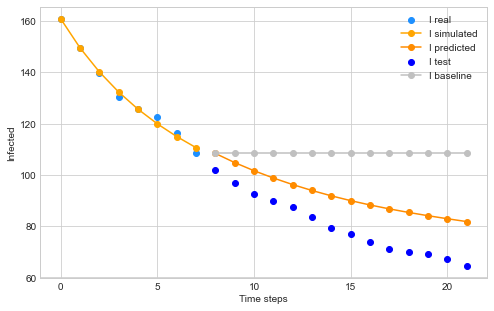

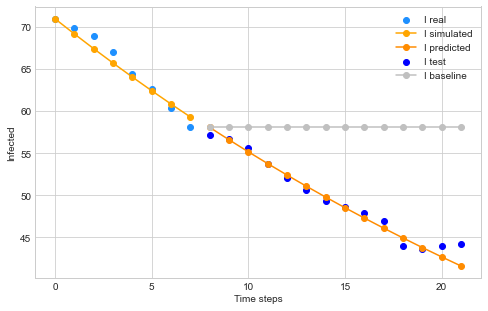

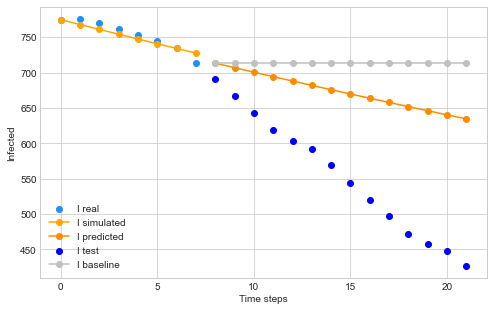

In [19]:
# create an object of the class
w_tuned = WindowFit(window_size=best_window_size, steps_ahead=14, data=test_data, eval_mode='WF')
# get a random train and test window
window_train, window_test = w_tuned.random_windows()
# fit the model and get the predictions
S_simulated, I_simulated = w_tuned.fit_predict(window_train, return_only_predictions=True)
# fit model and plot the results for 3 random windows
w_tuned.plot_windows(max_subplots=3)

The overall performance of these models is evaluated and shown in tabular form by time horizon (SIS and baseline). 

In [20]:
# evaluate the model
evaluation = w_tuned.evaluate()
# show the evaluation as DataFrame
sis_evaluation = pd.DataFrame(evaluation)
sis_evaluation

,step_1,baseline_step_1,step_2,baseline_step_2,step_3,baseline_step_3,step_4,baseline_step_4,step_5,baseline_step_5,...,step_10,baseline_step_10,step_11,baseline_step_11,step_12,baseline_step_12,step_13,baseline_step_13,step_14,baseline_step_14
RMSLE,0.045683,0.045683,0.062216,0.089843,0.081880,0.133411,0.103286,0.176490,0.125809,0.219115,...,0.277283,0.432318,0.311440,0.474020,0.345651,0.514958,0.380613,0.555425,0.417087,0.595567
MAE,8.763728,8.763728,11.056802,17.513461,14.122003,26.309242,17.766265,35.115103,22.171031,43.890293,...,54.129306,87.669258,61.919458,96.333872,70.270351,104.946571,79.322002,113.421828,89.300844,121.881596
RMSE,13.293781,13.293781,17.106828,26.295915,22.121768,39.076260,27.906459,51.716752,34.294175,64.229689,...,89.116503,125.451532,103.998084,137.179553,120.061857,148.647797,137.901054,159.884066,157.919203,170.904728
MAPE,0.035897,0.035897,0.046487,0.071053,0.059309,0.106106,0.073274,0.141019,0.088816,0.176014,...,0.190491,0.354352,0.213636,0.390895,0.237162,0.427563,0.261921,0.464608,0.289434,0.502094


,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,step_10,step_11,step_12,step_13,step_14
RMSLE,0.05,0.06,0.08,0.10,0.13,0.15,0.18,0.21,0.24,0.28,0.31,0.35,0.38,0.42
MAE,8.76,11.06,14.12,17.77,22.17,27.17,32.90,39.52,46.66,54.13,61.92,70.27,79.32,89.30
RMSE,13.29,17.11,22.12,27.91,34.29,41.77,51.20,62.59,75.28,89.12,104.00,120.06,137.90,157.92
MAPE,0.04,0.05,0.06,0.07,0.09,0.11,0.12,0.15,0.17,0.19,0.21,0.24,0.26,0.29


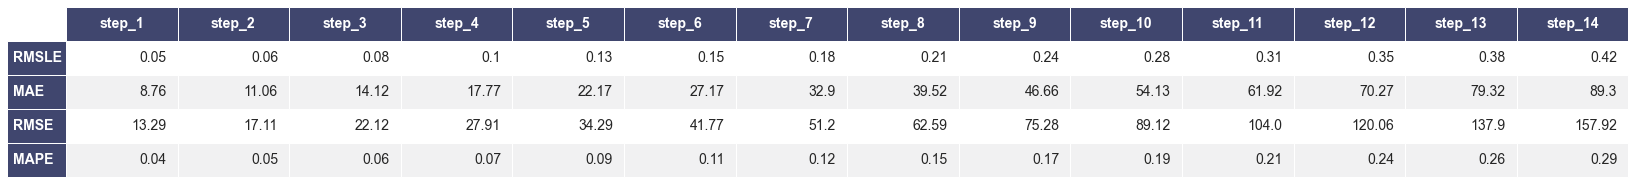

In [48]:
# save the evaluation as csv in analysis folder of data
data_results_relative_path = '../data/model-evaluation-results'
file_name_sis_evaluation = 'ci_SIS_evaluation_w8_target_y'
path_to_save_sis_evaluation = os.path.join(data_results_relative_path, file_name_sis_evaluation)
eval_w8 = sis_evaluation.T[::2].T.round(2)

eval_w8.to_csv(path_to_save_sis_evaluation)
show_eval_table_and_save(eval_w8, path_to_save_sis_evaluation)

In [22]:
# print(eval.to_latex(header=[f'h={i}' for i in range(1,15)]))

Now, these results are analyzed graphically. This facilitates and speeds up interpretation of the errors.

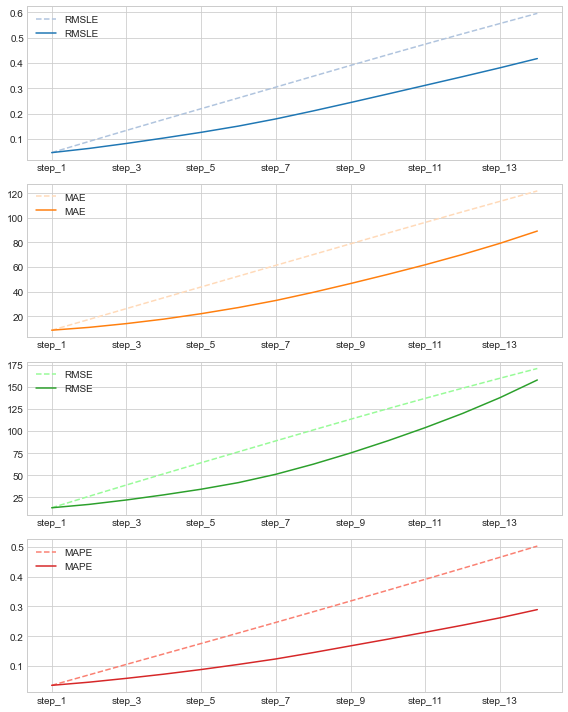

In [23]:
plot_evaluation_evolution_through_steps(sis_evaluation)

**Interpretation of the plot**
- All metrics show that the SIS model outperforms the baseline for every step considered. 
- All the graphs show an increase in error as the time horizon increases. This is to be expected, since uncertainty increases as the time horizon increases. 
- It can then be concluded that this model is able to generate more accurate predictions than repeating the last observed value 14 steps forward. Therefore, it may be useful to take your results into consideration when making decisions. 

## Forecasts exploration

The predictions generated are now explored to visually study the results. Note that in this type of model, the predictions generated depend only on the train **window**, not on the train **set** (abuse of notation). Results that will be used to compare the performance of this type of model with other types of models will be those calculated on the test set, however in this section all results are displayed to study the dynamics of the series and the accuracy and behaviour of this type of model. 

In [24]:
# define a window for test data
w_test = WindowFit(window_size=best_window_size, steps_ahead=14, data=test_data, eval_mode='WF')	

# get a dataframe with all predictions per step
y_fit_test = w_test.get_predictions_df(subset='test')

In [25]:
# same for train subset if necessary
w_train = WindowFit(window_size=best_window_size, steps_ahead=14, data=train_data, eval_mode='WF')	
y_fit_train = w_train.get_predictions_df(subset='train')

A sample of the first five sets of predictions are shown in the following table:

In [26]:
y_fit_train.head(5)

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,y_step_11,y_step_12,y_step_13,y_step_14
Date,,,,,,,,,,,,,,
2020-02-29,0.128215,0.179368,0.250949,0.351010,0.491007,0.687035,0.961228,1.343830,1.879890,2.631094,3.681259,5.147248,7.200138,10.076005
2020-03-01,0.168816,0.243851,0.352271,0.508732,0.734864,1.061785,1.533265,2.213536,3.198830,4.622401,6.672578,9.631201,13.919587,20.109769
2020-03-02,0.247882,0.371020,0.555386,0.831039,1.244038,1.862511,2.785747,4.169326,6.243570,9.343565,13.970355,20.918791,31.316877,46.864586
2020-03-03,0.401739,0.619576,0.955629,1.473315,2.272682,3.505400,5.401667,8.333841,12.857680,19.808103,30.539078,47.120680,72.645086,111.986246
2020-03-04,0.583376,0.941037,1.518120,2.447984,3.949958,6.369844,10.269881,16.575440,26.724456,43.066886,69.504564,112.046726,180.460905,290.877212


The actual series (begining at time 1 instead of time 0) is plotted against the set of predictions below.

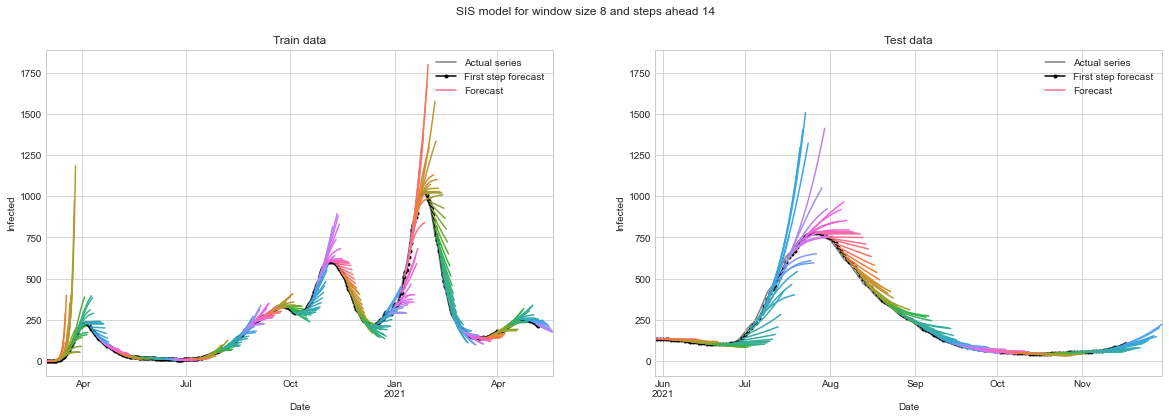

In [27]:
palette = dict(palette='husl', n_colors=64)
# fig, ax1 = plt.subplots(1, 1, figsize=(11, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# train data
ax1 = df['Infected'][y_fit_train.index].plot(color='grey', zorder=0, ax=ax1)
y_fit_train['y_step_1'].plot(ax=ax1, color='k', style='.-', legend='First Forecast')
plot_multistep(y_fit_train, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Actual series', 'First step forecast', 'Forecast'])

# test data
ax2 = df['Infected'][y_fit_test.index].plot(color='grey', zorder=0, ax=ax2)
y_fit_test['y_step_1'].plot(ax=ax2, color='k', style='.-', legend='First Forecast')
plot_multistep(y_fit_test, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Actual series', 'First step forecast', 'Forecast'])

# set title
ax1.set_title('Train data')
ax2.set_title('Test data')
fig.suptitle('SIS model for window size 8 and steps ahead 14')

# label axes
ax1.set_xlabel('Date')
ax1.set_ylabel('Infected')
ax2.set_xlabel('Date')
ax2.set_ylabel('Infected')

# set same y scale for both axes
ax2.set_ylim(ax1.get_ylim())

plt.show()

For each step, a set of 14 forecasts are obtained from SIS models as shown in the figure.

For each time horizon, it can be seen how the predictions follow the trend of infected past data, in particular the last 8 data points. When the slope of the past observations is smooth, the predictions appear accurate; when there is a sharp, positive change in the slope, the predictions are extremely different from the actual data. The interpretation is that if the conditions of the last 8 days are maintained, this number of infected cases is expected.  

This would suggest that some external virus containment measure has to be applied. In reality this is likely to have occurred, which explains why the peaks of infection have been more successfully contained than the model indicates. There are therefore two different readings: the model is inaccurate because its predictions do not correspond to the actual cases observed in the future; the actual future cases do not correspond to the predictions because, in anticipation of the predictions, measures were implemented to prevent them. For example, the predictions at the beginning of the training set foresaw a possible outbreak, but it is at that time that the first control and prevention measures are implemented. It follows that the evaluation of this - and any - model may not be realistic, as the part of the series from which the characteristics and results were extracted may have been modified. This can also be confirmed by looking at the periods of the series, and the corresponding predictions, where no changes occur and near perfect accuracy can be seen. This analysis is analogous to the rest of the models. 

As the graph may be too dense to properly compare the forecasts, the 1-, 7- and 14-day forecasts are now studied.

In [28]:
def compare_forecasts_at_step(y_fit, baseline, lower_ci=None, upper_ci=None, test_series=None, step=1):
    """ Compare the forecasts at a given step """

    forecasts_step = y_fit[f'y_step_{step}'].values
    base = baseline
    fig = plt.figure(figsize=(12, 5))

    plt.plot(test_series[step-1:len(y_fit)+step-1], marker='.', label='Actual series')
    plt.plot(forecasts_step, marker='.', label=f'Forecast step {step}')
    plt.plot(base, '-.', label='Baseline')

    # if prediction intervals are available, plot them
    try:
        lower_ci_step = lower_ci[f'ci_lower_step_{step}'].values
        upper_ci_step = upper_ci[f'ci_upper_step_{step}'].values
        plt.fill_between(range(len(forecasts_step)), lower_ci_step, upper_ci_step, color='lightgrey', alpha=0.5)
    except:
        pass

    plt.title(f'Comparison of forecasts at step {step}')
    plt.legend()
    plt.show()

In [29]:
# obtain data for the plots for both train and test data
baseline_test = w_test.baseline[1][:,0]
infected_test = test_data[1][w_test.window_size+1:]

baseline_train = w_train.baseline[1][:,0]
infected_train = train_data[1][w_train.window_size+1:]

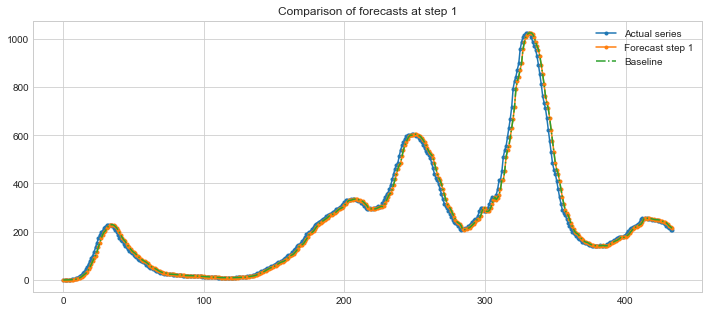

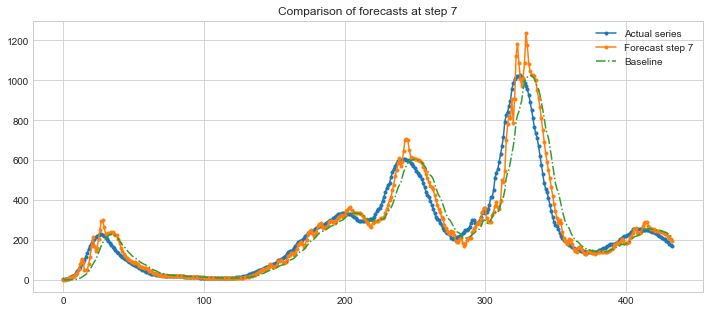

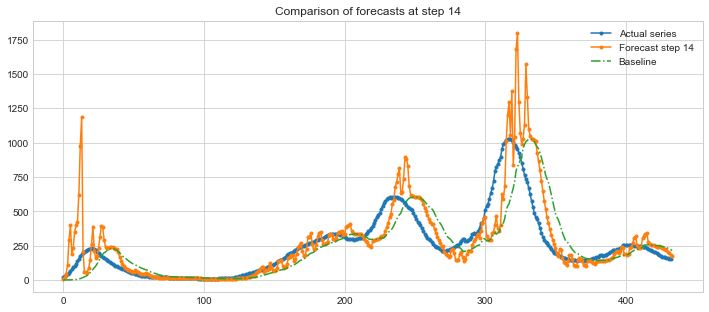

In [30]:
# train forecasts at time steps 1, 7 and 14 are explored first
for step in [1, 7, 14]:
    compare_forecasts_at_step(y_fit_train, baseline_train, test_series=infected_train, step=step)

**Interpretation of the plots**

- The one-day predictions generated by the SIS are the same as those generated by the baseline, i.e. the system prediction for the day after is to repeat the previous step. This can be confirmed checking the evaluation of step one.
- The model does not predict sharp peaks until there has been a change in the trend suggesting an increase or decrease in cases. Although it cannot predict these peaks, the slope of successive 14-day forecasts can be studied. If they have a steep upward or downward slope, it can be thought of as a significant increase or decrease.

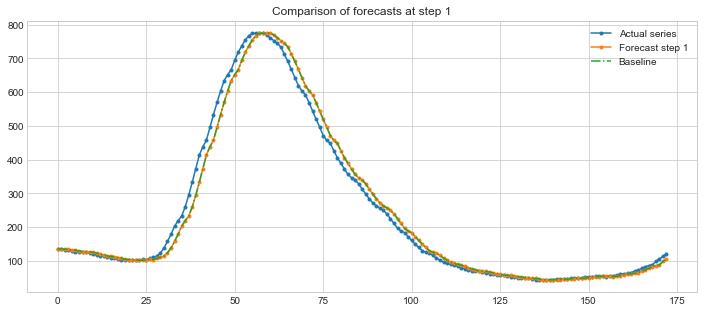

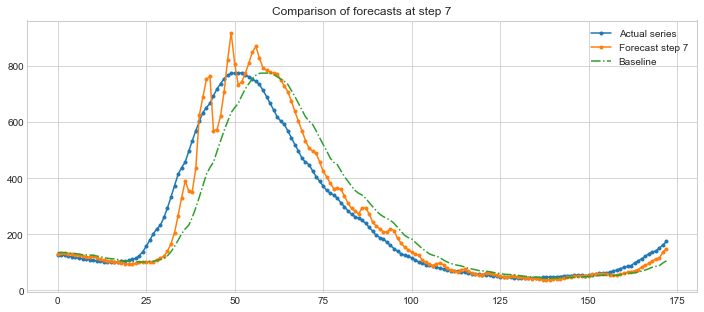

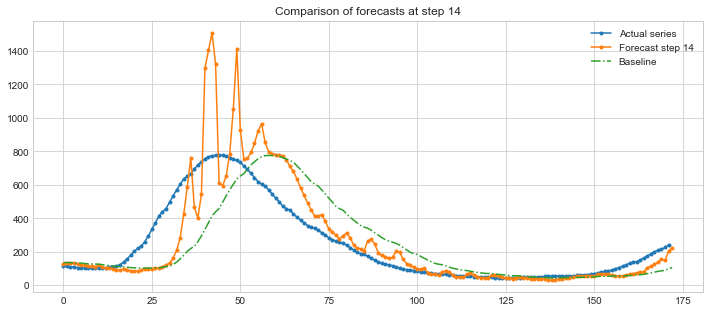

In [31]:
# test forecasts at time steps 1, 7 and 14 are explored now
for step in [1, 7, 14]:
    compare_forecasts_at_step(y_fit_test, baseline_test, test_series=infected_test, step=step)

The same can be said about the test set.

# Basic reproductive number $R_0$

Contrary to what seems to be currently established, in a model it is not only the predictions that matter, but also the model's capacity to provide information about the phenomenon under study. The information provided by the epidemiological models is given by their $\beta$ and $\gamma$ parameters and their evolution through time. These provide information on the existence and speed of spread of infection in a population.

In [32]:
w_r0 = WindowFit(window_size=best_window_size, steps_ahead=14, data=train_data, eval_mode='WF')
w_r0_pred = w_r0.get_all_predictions(horizon=1)	# to call the method fit_predict and estimate beta and gamma parammeters
w_r0_beta = w_r0.beta_series
w_r0_gamma = w_r0.gamma_series

If the estimated parameters are negative, the model or the results would not make sense, so this has to be checked. If the below cell does not print any value, then there is no negative parameter.

In [33]:
def check_negativeness_of_params(beta, gamma):
    """ Check if beta and gamma are negative """
    if beta < 0:
        print('Beta is negative:', beta)
    if gamma < 0:
        print('Gamma is negative:', gamma)

for beta, gamma in zip(w_r0_beta, w_r0_gamma):
    check_negativeness_of_params(beta, gamma)

Plot the evolution of parameters:

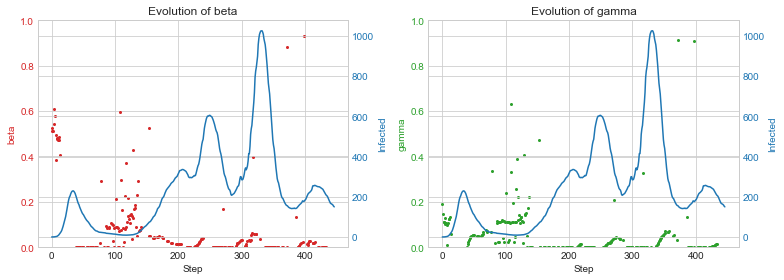

In [34]:
fig, (ax1, ax11) = plt.subplots(1, 2, figsize=(11, 4))

color = 'tab:red'
ax1.set_xlabel('Step')
ax1.set_ylabel('beta', color=color)
ax1.scatter(np.arange(len(w_r0_beta)),w_r0_beta, color=color, s=4)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Infected', color=color)  # we already handled the x-label with ax1
ax2.plot(train_data[1][best_window_size:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.set_title('Evolution of beta')

color = 'tab:green'
ax11.set_xlabel('Step')
ax11.set_ylabel('gamma', color=color)
ax11.scatter(np.arange(len(w_r0_gamma)),w_r0_gamma, color=color, s=4)
ax11.tick_params(axis='y', labelcolor=color)
ax11.set_ylim(0, 1)
ax21 = ax11.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax21.set_ylabel('Infected', color=color)  # we already handled the x-label with ax1
ax21.plot(train_data[1][best_window_size:], color=color)
ax21.tick_params(axis='y', labelcolor=color)

ax21.set_title('Evolution of gamma')

fig.tight_layout() 
plt.show()

The best parameters found take values of e.g. $\gamma \approx 200$, which does not make epidemiological sense, as it would be assuming that an individual recovers after 200 days. Therefore, this model should be understood as a regression model and not as one that correctly captures the epidemiological evolution.

**Note**

In the previous graph, the scale was limited to 0-1 to see if there were values that made sense, although this is difficult to determine and it is generally concluded that the model fails in this aspect. It makes sense, on the other hand, as the assumptions initially imposed are too restrictive and in this particular virus are far from being verified.

# Residuals exploration

If the model has succeeded in capturing all the information and structure of the available data, then the residuals should be random. That is, residuals are the part left that cannot be predicted. The exploration of these residuals provides a better understanding of the model and its scope. If the study suggests that the residuals are not random, i.e., that they follow some pattern or structure, then the model can be improved. 

Residuals are defined as the subtraction of the observed values minus the predicted values. In practice, standarized residuals are often used to detect unexpected values or outliers. They are defined as the residual divided by an estimate of the standard deviation of the residuals, so they measure the degree of difference between observed and expected values.

The residual errors for a time step ahead (t+14) using the training and test subsets of data are obtained below:

In [36]:
residuals_train = w_train.get_residuals(horizon=14) # residuals for the time step (t+14) with train set
residuals_test = w_test.get_residuals(horizon=14) # residuals for the time step (t+14) with test set

The graphic exploration of (standarized) residuals can be summarized in terms of the following plots:
- Residuals line plot
- Histogram and density plot of the residuals
- Normal Q-Q residual plot of residuals
- Correlogram or autocorrelation plot of residuals

**Residuals study on train set**

The analysis begin with train set study. Although it should be noted that in this case, the results of the model only depend on the train and test window and not on the train subset and test subset, which has been divided in this way for purposes of comparison with future types of models. However, in order to study and understand the dynamics of the time series and the model on it, both sets are studied. 

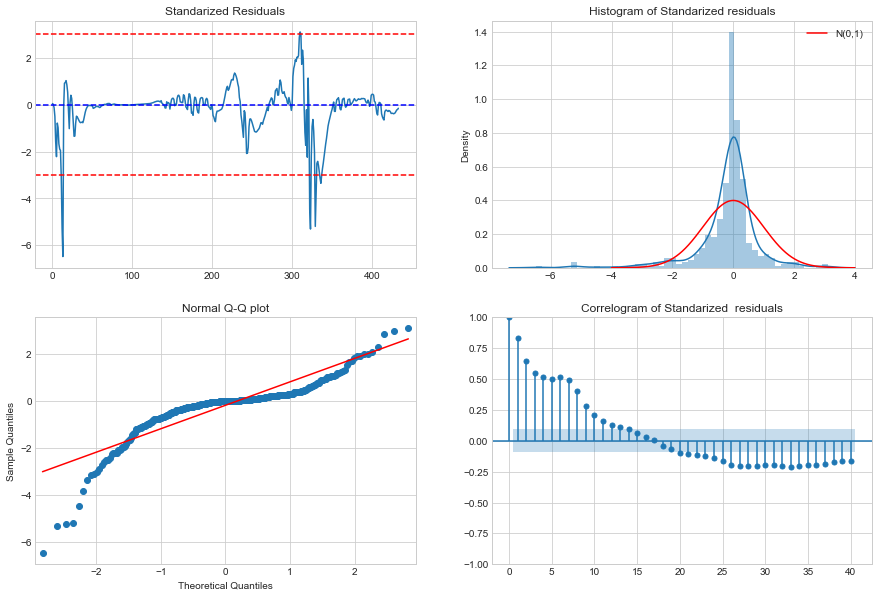

In [37]:
diagnostic_checking_residuals(residuals_train)

Some statistics are now calculated to provide information on how the values are distributed around zero. If the model was perfect, then the mean would be zero; a negative mean represents a negative bias in the forecasts; a positive mean represents a positive bias.

In [38]:
# characterize the residuals
residuals_stats(standarize_residuals(residuals_train))

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
0,434.0,-0.172965,1.001154,-6.478049,-0.325594,-0.002368,0.197502,3.106097,9.395749,-1.926465


- Observing the line plot of the standardized residuals though time, it can be seen that they are not random and that there is a correlation between them as confirmed by the correlogram. Values exceeding $\pm 2$ could be considered outliers, several of which are discussed below. If the model was perfect, the resulting line plot should be iid noise, showing the residuals distributed around zero (zero mean) with no pattern (trend, seasonal components, etc.). 
- The standardized residuals do not follow a standard normal distribution: although they are centered around zero and their standard deviation is close to 1, they exhibit negative skewness and high positive kurtosis. Most residuals seem to be near to zero, although there are some extremely large errors (large tails).
- Q-Q plot confirms the previous point and highlights the outliers.
- Finally, the autocorrelation plot shows the relation between a observation with prior observations in time. Ideally the residuals should not be correlated. This correlogram suggests that there is autocorrelation between observations that the model does not capture. 

The points that the residual study has identified as outliers are now compared to find a possible explanation for the model's inability to capture that information. Since residuals were defined as Observed-Predicted values, a hihgly negative (standarized) residual implies that the predicted value is much higher than the observed value; conversely, a hihgly positive (standarized) residual implies that the predicted value is much lower than the observed value.

The following graph identifies the outliers and classifies them into negative and positive outliers to highlight overestimation (the model expects more infected cases than the actual observed) or underestimation (the model expects less cases than observed), respectively.

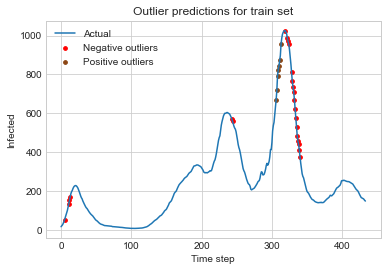

In [39]:
# predicted outliers in the train set
standarized_residuals_train = standarize_residuals(residuals_train)
outliers_low, = np.where(standarized_residuals_train < -2)
outliers_high, = np.where(standarized_residuals_train > 2)

plt.plot(train_data[1][w_train.window_size+(w_train.steps_ahead-1):], label='Actual')
plt.scatter(outliers_low, train_data[1][w_train.window_size+(w_train.steps_ahead-1):][outliers_low], color='r', s=14, label='Negative outliers')
plt.scatter(outliers_high, train_data[1][w_train.window_size+(w_train.steps_ahead-1):][outliers_high], color='saddlebrown', s=14, label='Positive outliers')

plt.legend()
plt.title('Outlier predictions for train set')
plt.xlabel('Time step')
plt.ylabel('Infected')
plt.show()

The graph can be interpreted in the following way:
- It can be said that the model more or less accurately predicts almost all points up to 14 using the fixed window size of 11.
- The model is unable to accurately predict the points marked as outliers in the graph.
- The red dots mean that the corresponding trained SIS highly overestimates the future value; the brown dots mean that the corresponding trained SIS highly underestimates the future value.
- The fact that so many outliers occur at the peak around the 300 point can be interpreted to mean that with the previous 11 days of data, an SIS model will not be able to detect this type of change in dynamics in time (14 days in the future).

**Residuals study on test set**

Same analysis is applied to test subset now.

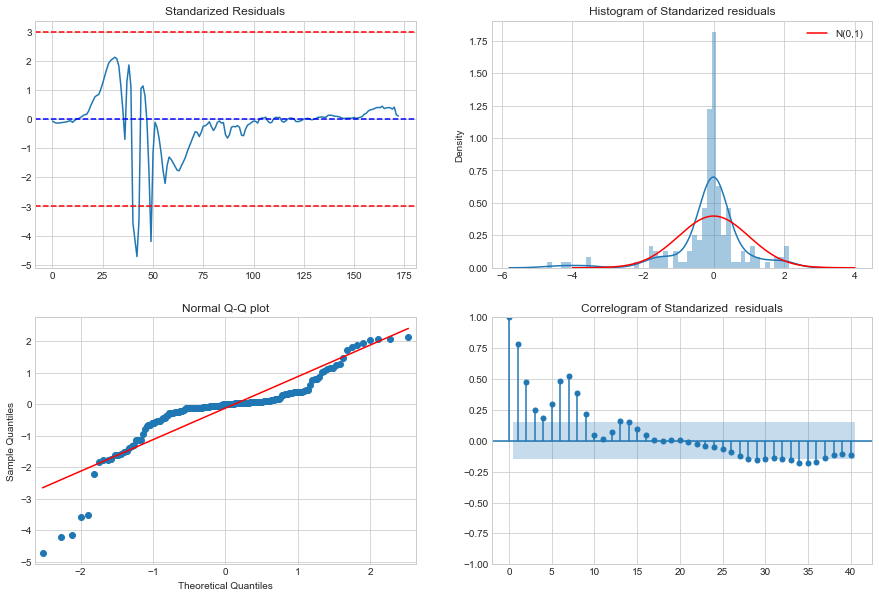

In [40]:
diagnostic_checking_residuals(residuals_test)

In [41]:
# characterize the residuals
residuals_stats(standarize_residuals(residuals_test))

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
0,173.0,-0.123329,1.002903,-4.720971,-0.247632,0.009232,0.136712,2.131765,5.776535,-1.525408


Practically the same thing that has been said about the train set can be said about the test set:
- The line plot of standarized residuals has not the shape of white noise and some outliers can be observed.
- Distribution of standarized residuals has zero mean and standard deviation of 1, however a high positive kurtosis and negative skewness can be observed.
- The Q-Q plot shows that this distribution differs from the normal one and highlights the outliers that were intuited by the above.
- The structure represented by the correlogram does not resemble that of white noise: the residuals are not random and the model has not captured all the relationship between successive values of the time series.

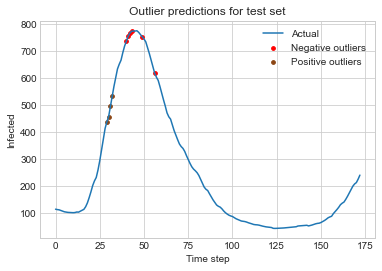

In [42]:
# predicted outliers in the test set
standarized_residuals_test = standarize_residuals(residuals_test)
outliers_low, = np.where(standarized_residuals_test < -2)
outliers_high, = np.where(standarized_residuals_test > 2)

plt.plot(test_data[1][w_test.window_size+(w_test.steps_ahead-1):], label='Actual')
plt.scatter(outliers_low, test_data[1][w_test.window_size+(w_test.steps_ahead-1):][outliers_low], color='r', s=14, label='Negative outliers')
plt.scatter(outliers_high, test_data[1][w_test.window_size+(w_test.steps_ahead-1):][outliers_high], color='saddlebrown', s=14, label='Positive outliers')

plt.legend()
plt.title('Outlier predictions for test set')
plt.xlabel('Time step')
plt.ylabel('Infected')
plt.show()

This graph is interpreted similarly to the one shown for train, concluding that the model is not able to predict at time the sharp rise in the number of cases.

# Conclusion:

The assumptions of the model are not fulfilled and, consequently, the parameters cannot be estimated correctly. It thus loses its interpretability in epidemiological terms and this study would be merely a regression analysis. On the other hand, the predictions do not turn out to be too wrong. Finally, it should be noted that the computational cost of finding the best window size is too high. 